In [1]:
# """
# A model for the C-P-U evolution 310-290 Ma
# Author: Shihan Li
# Several steps:
# 1. Auto spin to steady state in the beginning
# 2. Inverse to fit pco2 and d235U


# Initial steady state:
# 1. t = 310Ma
# 2. pCO2 = 500e-6
# 3. o = 4.4e19 (after COPSE results)
# 4. d13c = 4.42 (after proxy records)
# 5. d235u = -0.10-0.27 (after proxy records)

# Forcing：
# 1. linear weatherability scale for silicate weathering
# 2. linear weatherability scale for carbonate weathering
# 3. rapid carbon emissions
# """

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.optimize import fmin_l_bfgs_b, fmin

import timeit
import pandas as pd
import matplotlib.pyplot as plt
import corner

import functions as fts               # functions for ODE
import emcee

from datetime import datetime

In [87]:
(4.79e7 - 5.7e6 - 6.2e6 - 3.6e7)/1e6      

0.0

In [156]:


### load the target data
target = pd.read_csv('For_inv6.csv')

'''--------------------------    Initial fluxes at t = 310ma -------------------------------- '''

# Constants
k_logistic = 12              # new determines slope of logistic anoxia function, COPSE_reloaded, Clarkson et al. 2018
k_uptake = 0.5000            # new determines efficiency of nutrient uptake in anoxia function; COPSE_reloaded; Clarkson et al. 2018
k_CtoK = 273.15    # convert degrees C to Kelvin
k_c = 4.3280                 # new determines climate sensitivity to CO2
k_l = 7.4000                 # new determines temperature sensitivity to luminosity
k_oxfrac = 0.9975            # updated initial oxic fraction
k_oceanmass = 1.397e21       # ocean mass (kg)

f_oxw_a = 0.5                # oxidative weathering dependency on O2 concentration
f_mocb_b = 2                 # marine organic carbon burial dependency on new production

a0 = 3.193e18       # atmosphere-ocean co2
o0 = 3.7e19         # atmosphere-ocean o2

pco2_i = 500e-6      
pco2atm0 = 280e-6
pco2pal_i = pco2_i/280e-6
a_i = a0 * np.sqrt(pco2pal_i)

delta_ocn_i = 4.46
delta_u_i = -0.10-0.27             # diagenetic correction, after Chen et al., 2022

k_oxidw = 5e12      # oxidative weatheirng + degassing, kept constant for simplicity
k_locb = 2.5e12     # continental organic C burial
k_mocb = 2.5e12     # marine organic C burial

# carbon isotope



delta_c = 4.5
delta_vol = -4
# organic weathering is kept free to close the 13c cycle

# organic carbon cycle follows the modern world
oxidw_i = k_oxidw
locb_i = k_locb
mocb_i = k_mocb

k6_fepb = 1e10               # updated Fe-P burial (mol/year)
k7_capb = 2e10               # updated Ca-P burial (mol/year)
k_mopb = 1e10                # organic-P burial in the ocean
k10_phosw = 4e10             # updated P weathering (mol/year)

newp0 = 117 * 2.2            # new production (umol/kg)
p0 = 2.2 * 1e-6 * k_oceanmass               # ocean (phosphate) phosphorus




# U cycle follows the modern value, after clarkson et al., 2018
u0 = 1.85e13         # modern U in the ocean

u_riv0 = 4.79e7       # river input
u_hydro0 = 5.7e6      # hydrothermal output
u_anox0 = 6.2e6       # anoxic sink
# u_anox0 = 18e6        # anoxic sink, sens test
u_other0 = 3.6e7       

u_other0 = u_riv0 - u_hydro0 - u_anox0

u_i = u0
u_riv_i = u_riv0
u_hydro_i = u_hydro0
u_anox_i = u_anox0
u_other_i = u_other0

delta_u_riv = -0.29
d_u_hydro = 0.2
delta_u_hydro = delta_u_i + d_u_hydro
d_u_anox = 0.5
delta_u_anox = delta_u_i + d_u_anox

delta_u_other = (u_riv_i * delta_u_riv - delta_u_hydro * u_hydro_i - delta_u_anox*u_anox_i)/u_other_i

d_u_other = delta_u_other-delta_u_i


# isotope fractionations
# d238u_riv = -0.29
# u_frac_anox = 0.5
# u_frac_sed = 0.0156
# u_frac_hydro = 0.2

silw_i = 3*1e12              # 1.25*modern
carbw_i = 8*1e12            # 1*modern
        

###########       Parameters for inversion       ################


temp_i = 285
# 15+273.15         # K, 283-287

po2pal_i = 1.1         # 1.0 - 1.2

ppal_i = 1.2         # 1.0 - 1.5

scale_silw = [2, 1.5]  # integrated long-term silicate weathering scale at t =  300, 290, 285 Ma

scale_locb = 1.05
# scale_u_riv = 0.8   # relative d_u_riv modifier to fit the lont-term d238u trend, chagne to others later
scale_d13c_oxidw = 1  # relative oxidw modifier to fit the long-term d13c trend

alpha = 0.33             # co2 dependence
te = 34                 # e-folding temperature dependence of continental weathering, 5-50, after Krissansen-Totton et a., 2018

p_on_silw = 1          # P dependence on silw flux

cinput = np.array([5,4,6,8,20])   # *1e19 Carbon for 4 carbon emission events, corresponding time is manually defined
# delta_cinput = np.array([-15,-9,-10, -9, -10])

# params =[ ppal_i, scale_silw[0], scale_silw[1], scale_carbw,
#            scale_locb, 
#          # p_on_silw,
#          cinput[0], cinput[1], cinput[2], cinput[3], cinput[4]]


raw_pco2 = pd.read_excel('raw_data.xlsx', sheet_name= 'pco2')
raw_u = pd.read_excel('raw_data.xlsx', sheet_name= 'u_raw')
raw_d13c = pd.read_excel('raw_data.xlsx', sheet_name= 'd13c_raw')

'''--------------------------    Probabilty function   -------------------------------- '''
def log_probability(params , option, *args):

    lp = log_prior(params)
    
    if not np.isfinite(lp) and option == 1:
        return -np.inf
    
    else:
        global fscale_silw, fscale_degassing, fscale_carbw, fscale_locb, ccdeg_i,o_i,p_i, fcinp, ANOX_i, phi_i, ppal_i, fscale_carbw, fscale_d13c_oxidw, p_on_silw, fccinp
        
        cinput = np.zeros(5)
        delta_cinput = np.zeros(5)
        
        scale_silw = np.zeros(3)
        ppal_i, scale_silw[0], scale_silw[1], scale_carbw, scale_locb, cinput[0], cinput[1], cinput[2], cinput[3], cinput[4], delta_cinput[0], delta_cinput[1], delta_cinput[2], delta_cinput[3], delta_cinput[4]  = params
        p_on_silw = 1.0
        scale_u_riv = 1
        
        
        
        
       
    
        
       
       
        
        
        
        fscale_silw = interpolate.interp1d([-310e6, -300e6, -290e6],[1,scale_silw[0], scale_silw[1]], bounds_error = False, fill_value = 1)
       
        # from geocarbsurf forcing
        fscale_degassing = interpolate.interp1d([-310e6, -300e6, -290e6],[1,1.21/1.14, 1.21/1.14], bounds_error = False, fill_value = 1)
#        
        fscale_carbw = interpolate.interp1d([-310e6, -290e6],[1,scale_carbw], bounds_error = False, fill_value = 1)
        fscale_locb = interpolate.interp1d([-310e6,  -290e6],[1,scale_locb], bounds_error = False, fill_value = 1)
    
        cinput_age = [-304.5e6, -303.90e6, -301.80e6, -300.80e6, -297.55e6, -296.5e6, -294.30e6, -293.73e6, -290.95e6, -290.03e6]
        # cinput_age = [-304.3e6, -304.15e6, -299.19e6, -298.43e6, -297e6, -296.4e6, -295.73e6, -293.91e6]
        cinput_rate = np.array(cinput)* 1e19 /np.array([304.5e6 - 303.90e6, -300.80e6+301.80e6, -296.5e6+297.55e6, 294.3e6-293.73e6, 290.95e6-290.03e6 ])    
        # cinput_rate = np.array(cinput)* 1e18 /np.array([-304.15e6 + 304.3e6, -298.43e6+299.19e6, -296.4e6+297e6, 295.73e6-293.91e6])    
        
        fcinp = interpolate.interp1d(cinput_age, [cinput_rate[0], 0, cinput_rate[1], 0, cinput_rate[2],0, cinput_rate[3],0, cinput_rate[4],0], kind = 'zero', bounds_error = False, fill_value = 0)
        fccinp = interpolate.interp1d(cinput_age, [delta_cinput[0], 0, delta_cinput[1], 0, delta_cinput[2],0, delta_cinput[3],0, delta_cinput[4],0], kind = 'zero', bounds_error = False, fill_value = 0)
      
        if option == 1:
            t_eval = np.sort(target.age.values)
        else:
            t_eval = args[0]
        
        
        ##############   initialize the model at t = 310Ma #################
        
        # Carbon
        global mccb_i
        mccb_i = silw_i + carbw_i    # total carbon burial to maintain the alkalinity balance, after COPSE
        o_i = o0 * po2pal_i
    
        
        ccdeg_i = silw_i
        
        # ap_i = ccdeg_i+oxidw_i-locb_i-mocb_i+carbw_i-mccb_i       # check the balance of carbon cycle
        
        # C isotope
        phi_i = 0.01614 * (a_i/a0)  # fraction of C in atmosphere:ocean
        
        d_locb_i, D_P_i, d_mocb_i, D_B_i, d_mccb_i, d_ocean_i, d_atmos_i = fts.Cisotopefrac(temp_i, pco2pal_i, po2pal_i, phi_i)
        
        
        delta_a_i = delta_ocn_i - d_ocean_i
        
        global delta_locb
        delta_locb = -30
        delta_mocb = delta_ocn_i- 28
        # delta_a_i+d_mocb
        
        
        delta_mccb_i = delta_a_i + d_mccb_i
        
        global delta_g
        delta_g = (locb_i * ( delta_locb) + mocb_i * (delta_mocb) - ccdeg_i * delta_vol - carbw_i * delta_c + mccb_i * delta_mccb_i)/oxidw_i
        
        moldelta_a_i = a_i * delta_a_i
        
        
        moldelta_ap_i = -ccdeg_i*delta_vol - oxidw_i*delta_g + locb_i*delta_locb + mocb_i*delta_mocb - carbw_i*delta_c + mccb_i*delta_mccb_i 
        
        
        # P cycle
        global p_i, newp_i, ANOW_i, mopb_i, fepb_i, capb_i, phosw_i
        p_i = p0 * ppal_i
        newp_i = 117 * (p_i/p0) * 2.2
        ANOX_i = 1/(1+np.exp(-k_logistic * (k_uptake * (newp_i/newp0)-po2pal_i)))   
        mopb_i = mocb_i * ((ANOX_i/1000)+((1-ANOX_i)/250))  # ocean burial
        fepb_i = (k6_fepb/k_oxfrac)*(1-ANOX_i)*(p_i/p0)
        capb_i = k7_capb * ((newp_i/newp0)**f_mocb_b)
        
        phosw_i = mopb_i + fepb_i + capb_i
        
        pp_i = phosw_i - mopb_i -fepb_i - capb_i
        
        # U cycle
        # up = u_riv_i - u_hydro_i - u_anox_i - u_other_i
        # moldelta_up_i = u_riv_i*d238u_riv - u_hydro_i*delta_u_hydro - u_anox_i*delta_u_anox - u_other_i*delta_u_other
        # print(up)
        # print(moldelta_up_i)
        moldelta_u_i = u_i * delta_u_i
        
        ystart = np.array([a_i, p_i, o_i, moldelta_a_i, u_i, moldelta_u_i])
        t0 = -310e6
        tfinal = -285e6
    
    
    
        start_time = timeit.default_timer()
        
        ysol = solve_ivp(derivs,(t0,tfinal), ystart, args={1}, t_eval=t_eval,method = 'LSODA',  max_step = 1e4)
        # ysol = derivs(-310e6, ystart, 1)
        
        # print("\n@ Starting integration")
        # print("[tstart tfinal]=[%.2e %.2e]\n" % (t0, tfinal))
        
        if np.isnan(ysol.y).any():
            return -np.inf
        
        else:
            t = ysol.t                # time
            y = ysol.y                # tracers

            nstep = len(t)

            params = np.zeros((nstep, 14))

            for i in range(nstep):
                params[i,:] = derivs(t[i], y[:,i], 0)

            df_params = pd.DataFrame(params)
            df_params.columns=['Temperature','ccdeg', 'oxidw', 'locb', 'mocb', 'silw', 'carbw', 'mccb', 'delta_ocn', 'phosw', 'mopb', 'fepb', 'capb', 'ANOX']
            df_params['Age'] = t

            df_sol = pd.DataFrame(ysol.y.T)
            df_sol.columns=['A',  'P',  'O', 'moldelta_A', 'U', 'moldelta_U']


            df_sol['Age'] = ysol.t
            df_sol['phosphate_m'] = (df_sol['P']/k_oceanmass) * 1e6  # umol/kg
            df_sol['p/p0'] = df_sol['phosphate_m']/2.2
            df_sol['U_m'] = (df_sol['U']/k_oceanmass)*1e6            # umol/kg
            df_sol['d235U'] = (df_sol['moldelta_U']/df_sol['U'])     # d235U
            df_sol['CO2_PAL'] = (df_sol['A']/a_i)**2
            df_sol['d13c'] = (df_sol['moldelta_A']/df_sol['A'])      # d13c

            df_sol['CO2atm'] = df_sol['CO2_PAL'] * pco2_i * 1e6
            df_sol['O2PAL'] = df_sol['O']/o0
            
            if option == 0:
                return df_sol.Age.values/1e6, df_sol.CO2atm.values, df_sol.O2PAL.values, df_params.ANOX.values*100, df_sol.d235U.values, fscale_silw(t), fcinp(t)/1e15, df_sol.d13c.values, df_params.Temperature.values, df_params.ccdeg.values, df_params.oxidw.values,df_params.locb.values, df_params.mocb.values, df_params.silw.values, df_params.carbw.values, df_params.phosw.values, df_params.mopb.values, df_params.fepb.values, df_params.capb.values, df_sol['p/p0'].values

            
            else:

                pco2_proxy = target['pco2'].values
                pco2_std = target['pco2_std'].values
                d13c_proxy = target['d13c'].values
                d13c_std = target['d13c_std'].values
                u_proxy = target['u'].values
                u_std = target['u_std'].values

                pco2_model = df_sol['CO2atm'].values
                d13c_model = df_sol['d13c'].values
                u_model = df_sol['d235U'].values



                sum_diff = sum((pco2_proxy-pco2_model)**2/(pco2_std**2)) 
                + sum((u_proxy-u_model)**2/(u_std**2)) + sum((d13c_proxy-d13c_model)**2/(d13c_proxy**2))
                sum_diff += sum(np.log(2*np.pi*pco2_std**2))+sum(np.log(2*np.pi*u_std**2))+sum(np.log(2*np.pi*d13c_std**2))





                return lp-0.5 * sum_diff
#             return 0



def derivs(t, y, switch):
    # if t<-310e6:
#     t = -310e6

    
    t_Ma = t/1e6
    
  


    # retrieve the parameters
    a, p, o, moldelta_a, u, moldelta_u = y

    delta_a = moldelta_a/a
    delta_u = moldelta_u/u
    # calcualte pco2
    po2pal = o/o0

    pco2pal = (a/a_i)**2
    pco2 = pco2_i * pco2pal
    phi = 0.01614 * (a/a_i)

    # temp = temp_i
    temp = temp_i + k_c * np.log(pco2pal) + k_l/570e6 * (t+310e6)
    
    diff_temp = temp - temp_i

    """---------------------  Carbon  -------------------------"""
    
    # degassing
    ccdeg = ccdeg_i * fscale_degassing(t)
   
    silw = fscale_silw(t) * silw_i * (pco2pal ** alpha) * np.exp(diff_temp/te) 
    
    
    
    
    carbw =  fscale_carbw(t) * fscale_silw(t) * carbw_i * (pco2pal ** alpha) * np.exp(diff_temp/te)      
    

    # oxidw
    po2pal_to_i = o/o_i
    oxw_fac = po2pal_to_i ** f_oxw_a
   
    oxidw = oxidw_i *  oxw_fac * fscale_degassing(t)
   
    

    # burial
    mccb = silw + carbw
    locb =   locb_i * fscale_locb(t) 
    
    
    mocb = mocb_i * (p/p_i) ** 2
   

    ap = ccdeg + oxidw  - locb - mocb - silw + fcinp(t)/12
    
    
    
   
   

    """--------------------- C isotope  -------------------------"""
    d_locb, D_P, d_mocb, D_B, d_mccb, d_ocean, d_atmos = fts.Cisotopefrac(temp, pco2pal * pco2pal_i, po2pal, phi * np.sqrt(pco2pal_i))

    delta_mccb = delta_a + d_mccb
    delta_ocn = delta_a + d_ocean
    
#     delta_locb = -30
    delta_mocb = delta_ocn-28
    
    
    # moldelta_ap =  -locb*(delta_a+d_locb) - mocb * (delta_a+d_mocb) + oxidw*delta_g  + ccdeg*delta_vol + carbw*delta_c - mccb*delta_mccb
    moldelta_ap =  -locb*(delta_locb) - mocb * (delta_mocb) + oxidw*delta_g + ccdeg*delta_vol + carbw*delta_c - mccb*delta_mccb + fcinp(t)/12 * fccinp(t)

     
    

    """--------------------- P  -------------------------"""
    # P cycle
    Pconc = (p/p0) * 2.2

    # marine new production
    newp = 117 * Pconc
    # anoxic
    ANOX =  1/(1+np.exp(-k_logistic * (k_uptake * (newp/newp0)-po2pal)))
    
    # phosw_i = k_phosw * silw_i/k_silw
    mopb = mocb * ((ANOX/1000)+((1-ANOX)/250))

    fepb = (k6_fepb/k_oxfrac)*(1-ANOX)*(p/p0)
    # fepb_i = (k_fepb/k_oxfrac)*(1-ANOX_i)
    # capb = capb_i * mocb/mocb_i 
    capb = k7_capb *  ((newp/newp0)**2)
    # capb_i = k_capb * ((newp_i/newp0))

    # phosphorous balance
    phosw = phosw_i * ((silw)/(silw_i)) ** p_on_silw


    pp = phosw-mopb-fepb-capb
    
    """--------------------- O  -------------------------"""
    op = locb + mocb - oxidw 
    
    # U cycle
    u_riv = u_riv_i * (silw/silw_i) 
    u_hydro = fscale_degassing(t) *u_hydro_i 
    u_anox = u_anox_i * (ANOX/ANOX_i) * u/u_i
    
    
    
    u_other =  u_other_i * (u/u_i)
    


    moldelta_up = u_riv * delta_u_riv  - u_hydro*(delta_u+d_u_hydro) - u_anox*(delta_u+d_u_anox)- u_other*(delta_u+d_u_other)

    up = u_riv - u_hydro - u_anox - u_other



    
    if switch:
        yp = np.array([ap, pp, op, moldelta_ap, up, moldelta_up])
        return yp
    else:
        params = np.array([temp, ccdeg, oxidw, locb, mocb, silw, carbw, mccb, delta_ocn, phosw, mopb, fepb, capb, ANOX])
        
        return params

def log_prior(theta):
    
    cinput = np.zeros(5)
    delta_cinput = np.zeros(5)
    scale_silw = np.zeros(2)
    ppal_i, scale_silw[0], scale_silw[1],  scale_carbw, scale_locb, cinput[0], cinput[1], cinput[2], cinput[3], cinput[4],  delta_cinput[0], delta_cinput[1], delta_cinput[2], delta_cinput[3], delta_cinput[4] = theta
    if 1.2<=ppal_i<=1.6 and np.all(scale_silw>=1) and np.all(scale_silw<=2) and 0.8<scale_carbw<1.2 and 0.9<scale_locb<1.1 and  0.5<=cinput[0]<=6 and 0.5<=cinput[1]<=6 and 0.5<=cinput[2]<=6 and .5<=cinput[3]<=6 and .5<=cinput[4]<= 6 and np.all(delta_cinput>=-25) and np.all(delta_cinput<=-5)  :
        return 0.0
    # return 0
    return -np.inf


In [193]:
# # Run the model if inversion results are not available, but it takes longer.


# from multiprocessing import Pool, cpu_count

# exp_name = 'inv6_v5'
# params_test =[  1.4, 1.5779317,   1.75, 1, 1,
#     # 0,  0,0,0,0,
#         3, 3        ,   2  , 2,  3    , -15,-9,-10, -9, -10
#   ]
# params_init = params_test
# with Pool() as pool:
                                                                                    
#     ndim = len(params_init)

#     pos = np.array(params_init) +  1e-1 * np.random.randn(40, ndim) * params_test
#     nwalkers, ndim = pos.shape

#     sampler = emcee.EnsembleSampler(
#         nwalkers, ndim, log_probability, args = [1],  threads = 25
#     )
#     pos, lnprob, rstate = sampler.run_mcmc(pos, 10000, progress=True)
# flat_samples = sampler.get_chain(discard=500, thin=100, flat=True)
# np.savetxt(f'ln_{exp_name}.dat', sampler.get_log_prob(flat = True))

# np.savetxt(f'{exp_name}.dat', flat_samples)

In [184]:
# Alternatively, read the model outputs from the previous running

# v3_2e4_prelim: ten parameters, cinput[4]<25, scale_locb with problem, discard = 400, thin = 200
# v3_2e4: ten parameters, cinput[4]<25, scale_locb without problem, discard = 400, thin = 200
# v3_4e4: ten parameters, cinput[4]<25, scale_locb without problem, discard = 400, thin = 200
# v2_2e4.dat: ten parameters, cinput[4]<40, scale_locb with porblem, discard =  300, thin = 175
# v2_4e4, discard = 400, thin = 150
# v3_4e4_v3 discard = 1000, thin = 600. All parameters for posterier probability.
# v3_4e4_10m discard = 1000, thin = 1000. All parameters for posterier probability.

# flat_samples = np.loadtxt('v4_v5.dat')
exp_name = 'inv6_v4'
flat_samples = np.loadtxt(f'{exp_name}.dat')


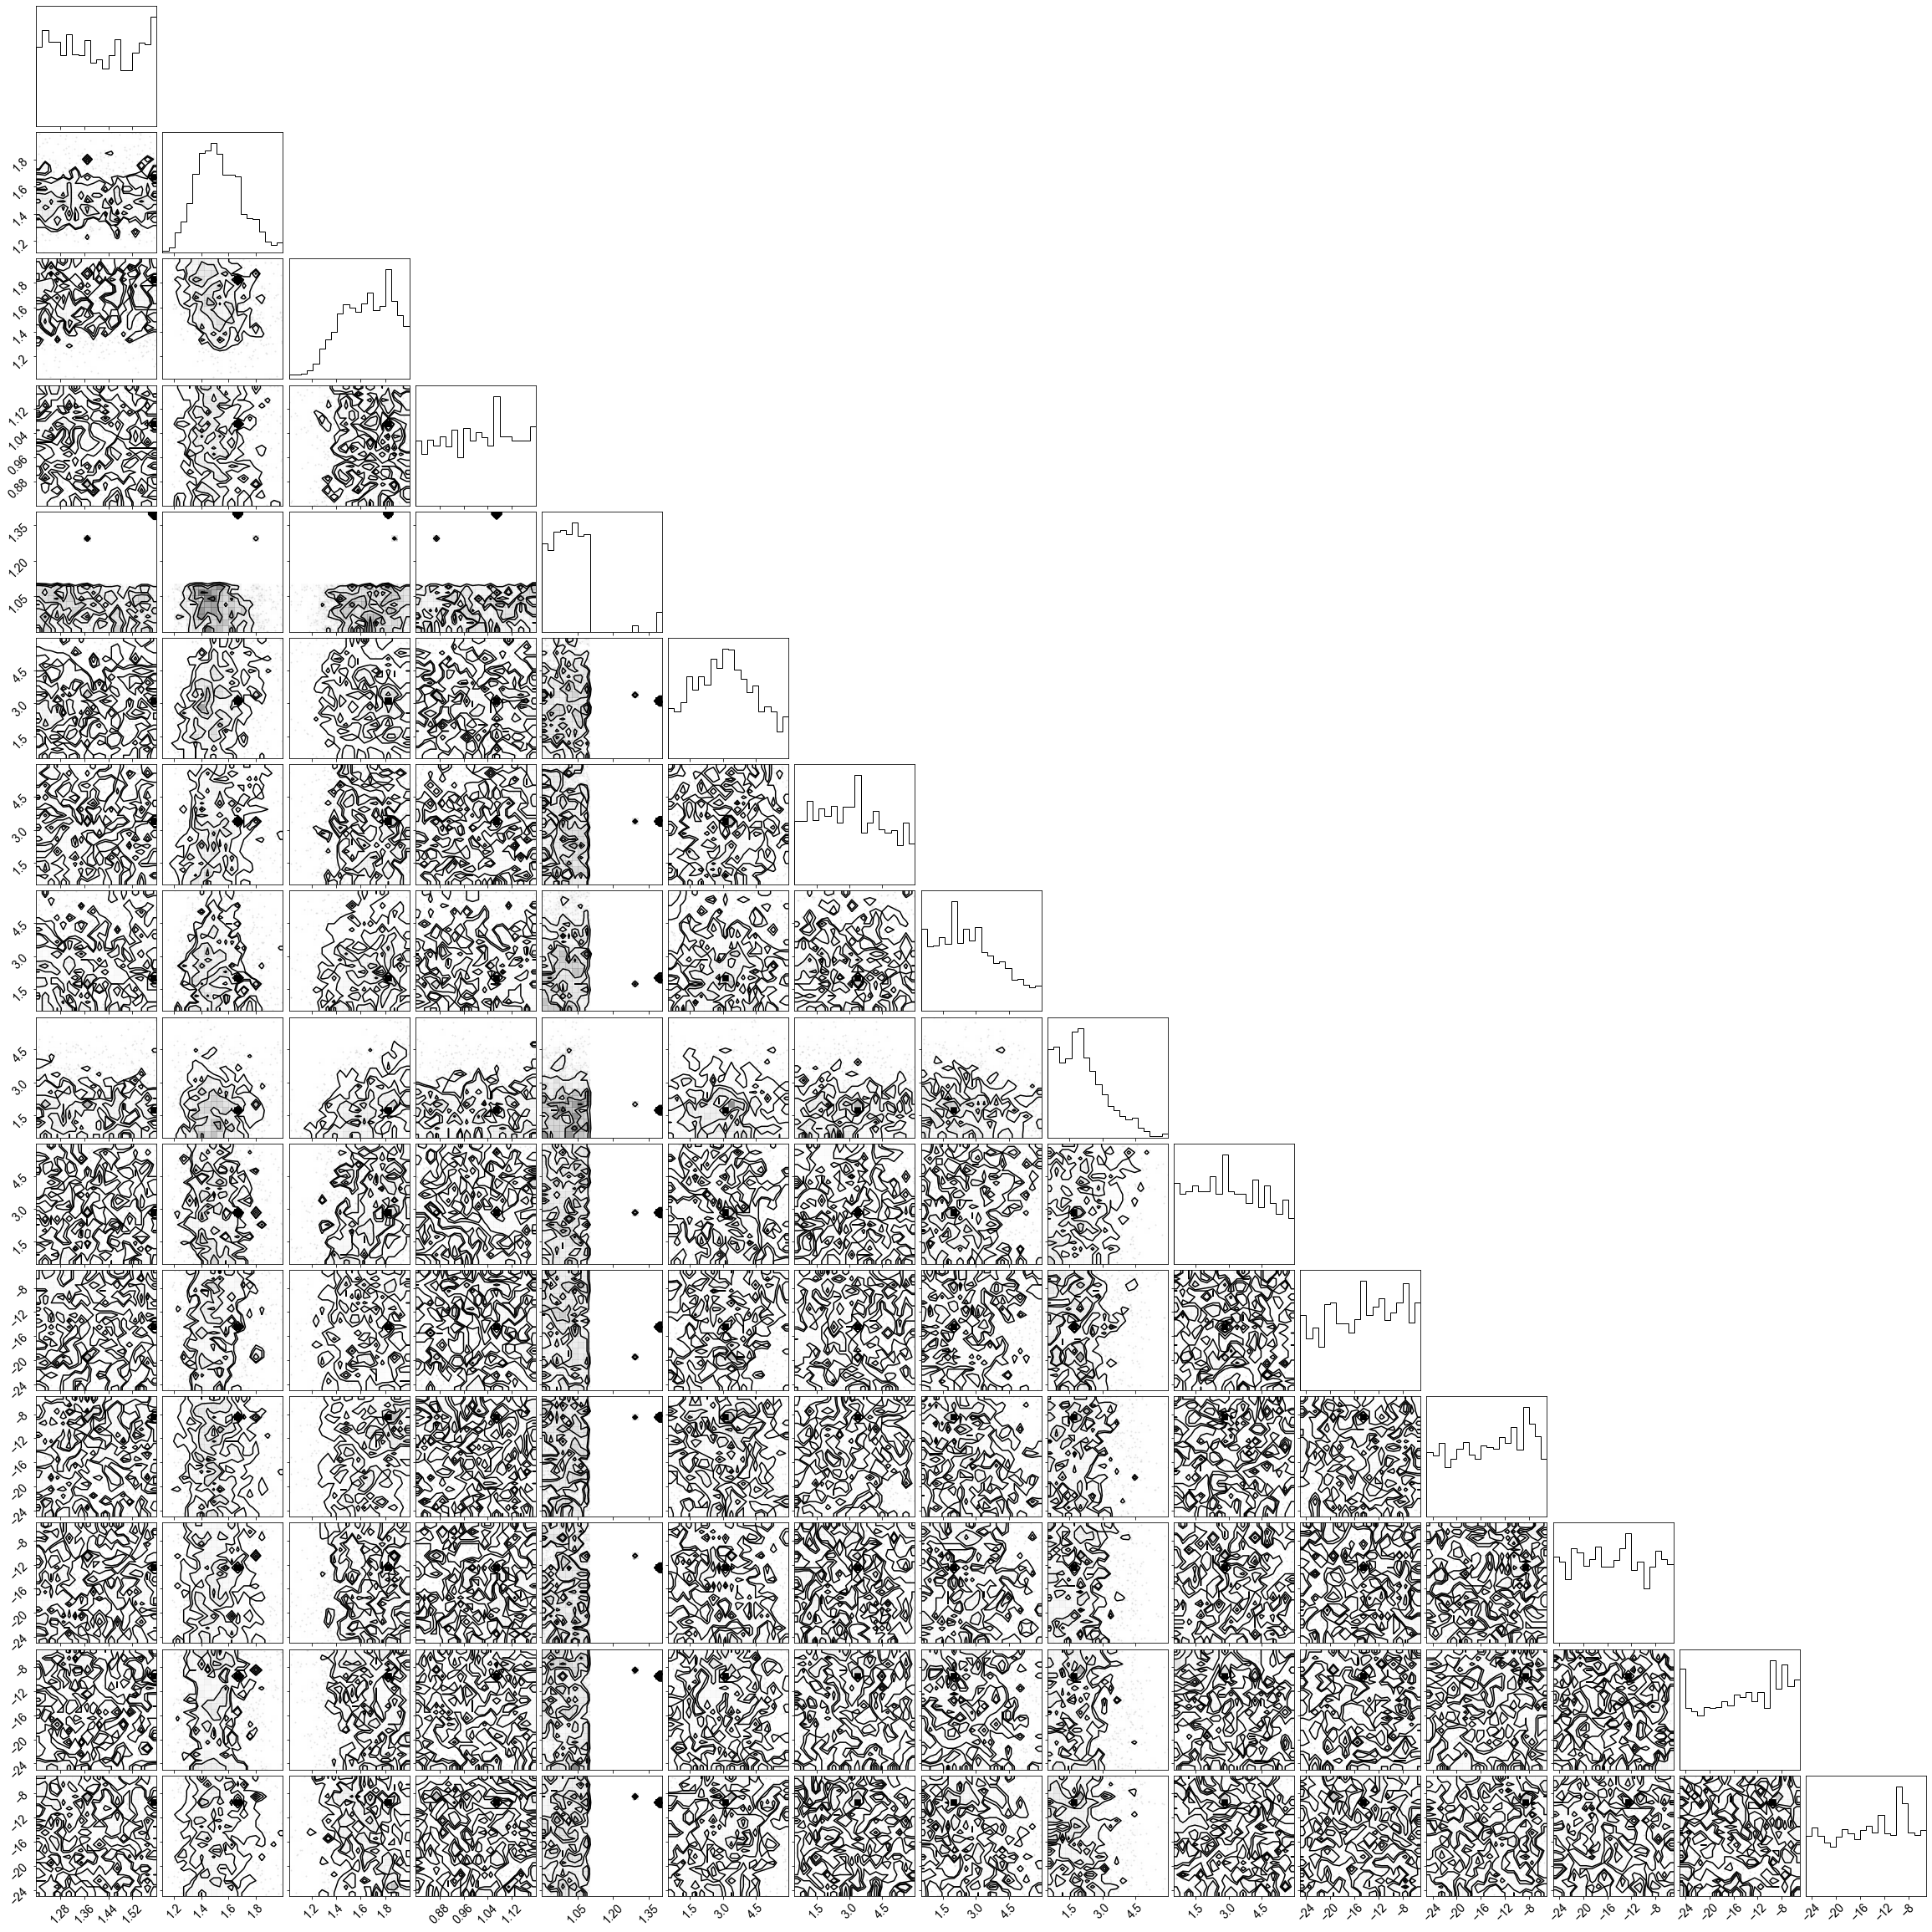

In [185]:
# plot and check the data
ndim = flat_samples.shape[1]
# fig, axes = plt.subplots(ndim, figsize=(12, 50), sharex=True)

labels = ["ppal_i", "scale_silw1", "scale_silw2", 'scale_carbw', "scale_locb",  'cinput1', 'cinput2', 'cinput3', 'cinput4', 'cinput5', 'deltac1', 'deltac2', 'deltac3', 'deltac3', 'deltac4', 'deltac5']


fig = corner.corner(
    flat_samples)

In [192]:
from IPython.display import display, Math
param_50_percent = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    param_50_percent[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{{2:.1f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
# v3_2e4_prelim: ten parameters, cinput[4]<25, scale_locb with problem, discard = 400, thin = 200
# v3_2e4: ten parameters, cinput[4]<25, scale_locb without problem, discard = 400, thin = 200
# v3_4e4: ten parameters, cinput[4]<25, scale_locb without problem, discard = 400, thin = 200
# v2_2e4.dat: ten parameters, cinput[4]<40, scale_locb with porblem, discard =  300, thin = 175
# v2_4e4, discard = 400, thin = 150
# v3_4e4_v3 discard = 1000, thin = 600. All parameters for posterier probability.
# v3_4e4_10m discard = 1000, thin = 1000. All parameters for posterier probability.

raw_pco2 = pd.read_excel('raw_data.xlsx', sheet_name= 'pco2')
raw_u = pd.read_excel('raw_data.xlsx', sheet_name= 'u_raw')
raw_d13c = pd.read_excel('raw_data.xlsx', sheet_name= 'd13c_raw')



t_eval = np.arange(-310e6, -290e6, 10000)

size = 1000
# len(flat_samples)

pco2 = np.zeros((size, len(t_eval)))
po2 = np.zeros((size, len(t_eval)))
anox = np.zeros((size, len(t_eval)))
d238u = np.zeros((size, len(t_eval)))
w_silw = np.zeros((size, len(t_eval)))
cinput = np.zeros((size, len(t_eval)))

Temperature = np.zeros((size, len(t_eval)))
ccdeg = np.zeros((size, len(t_eval)))
silw = np.zeros((size, len(t_eval)))
carbw = np.zeros((size, len(t_eval)))

oxidw = np.zeros((size, len(t_eval)))
locb = np.zeros((size, len(t_eval)))
mocb = np.zeros((size, len(t_eval)))

phosw = np.zeros((size, len(t_eval)))
mopb = np.zeros((size, len(t_eval)))
fepb = np.zeros((size, len(t_eval)))
capb = np.zeros((size, len(t_eval)))
p_p0 = np.zeros((size, len(t_eval)))

d13c = np.zeros((size, len(t_eval)))
w_locb = np.zeros((size, len(t_eval)))

inds = np.random.randint(len(flat_samples), size=size)

po2pal_i = 1.1

# def param_cal(i):
    
#     ind = inds[i]
#     param = np.copy(flat_samples[ind]) 
#     return log_probability(param,0, t_eval)


# with Pool() as pool:
#     results = pool.map(param_cal, range(size))
index = []
for i in range(size):
    ind = inds[i]
    param = np.copy(flat_samples[ind]) 
    if param[0]>1.6:
        continue
#     param[0] = 1.4
    else:
        index.append(i)
        age, pco2[i,:], po2[i,:], anox[i,:], d238u[i,:], w_silw[i,:], cinput[i,:], d13c[i,:], Temperature[i,:],ccdeg[i,:], oxidw[i,:], locb[i,:], mocb[i,:], silw[i,:], carbw[i,:], phosw[i,:], mopb[i,:], fepb[i,:], capb[i,:],p_p0[i,:]  = log_probability(param,0, t_eval)


In [25]:
#####################################

In [26]:
# Plot the figures


In [42]:
import os
import matplotlib as mpl
import matplotlib.patches as patches

from spylib import scolor, splot

mpl.rcParams['pdf.fonttype'] = 42
# Set font and set mathtext font the same with text font
mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
mpl.rcParams['mathtext.default'] = 'regular'
# Set tick size globally
# Set tick size globally
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16

plt.close("all")

In [28]:
cinp1 = flat_samples[:,5]
cinp2 = flat_samples[:,6]
cinp3 = flat_samples[:,7]
cinp4 = flat_samples[:,8]
cinp5 = flat_samples[:,9]

fsilw300 = flat_samples[:,1]
fsilw290 = flat_samples[:,2]
[-304.69e6, -303.90e6, -301.80e6, -300.80e6, -297.55e6, -296.5e6, -294.30e6, -293.73e6, -290.95e6, -290.03e6]
      
tinp = np.array([304.5e6 - 303.90e6, -300.80e6+301.80e6, -296.5e6+297.55e6, 294.30e6-293.73e6, 290.95e6-290.03e6 ])
c1 = np.percentile(cinp1, [16, 50, 84])
r1 = np.percentile(cinp1, [16, 50, 84])*1e19/tinp[0]/1e15

c2 = np.percentile(cinp2, [16, 50, 84])
r2 = np.percentile(cinp2, [16, 50, 84])*1e19/tinp[1]/1e15

c3 = np.percentile(cinp3, [16, 50, 84])
r3 = np.percentile(cinp3, [16, 50, 84])*1e19/tinp[2]/1e15

c4 = np.percentile(cinp4, [16, 50, 84])
r4 = np.percentile(cinp4, [16, 50, 84])*1e19/tinp[3]/1e15

c5 = np.percentile(cinp5, [16, 50, 84])
r5 = np.percentile(cinp5, [16, 50, 84])*1e19/tinp[4]/1e15

silw300 =  np.percentile(fsilw300, [16, 50, 84])
silw290 =  np.percentile(fsilw290, [16, 50, 84])

In [29]:
print("cinp1: ", c1)
print("cinp2: ", c2)
print("cinp3: ", c3)
print("cinp4: ", c4)
print("cinp5: ", c5)

print("fsilw300: ", silw300)
print("fsilw290: ", silw290)

print("percentile r1: ", r1)
print('percentile r2: ', r2)
print("percentile r3: ", r3)
print("percentile r4: ", r4)
print("percentile r5: ", r5)


cinp1:  [1.56374277 3.0943532  4.58676632]
cinp2:  [1.32472534 3.03932252 4.81900778]
cinp3:  [1.19204184 2.57380819 4.30091276]
cinp4:  [0.94914246 1.95349288 3.1552829 ]
cinp5:  [1.34345931 2.97201916 4.86647643]
fsilw300:  [1.36795087 1.51005873 1.68951667]
fsilw290:  [1.41939041 1.66257665 1.87115601]
percentile r1:  [0.02606238 0.05157255 0.07644611]
percentile r2:  [0.01324725 0.03039323 0.04819008]
percentile r3:  [0.01135278 0.02451246 0.04096107]
percentile r4:  [0.01665162 0.0342718  0.05535584]
percentile r5:  [0.01460282 0.03230456 0.05289648]


In [30]:
pco2_results = np.zeros((len(t_eval),5))
po2_results = np.zeros((len(t_eval),5))
anox_results = np.zeros((len(t_eval),5))
anox_results2 = np.zeros((len(t_eval),5))
d238u_results = np.zeros((len(t_eval),5))
w_silw_results = np.zeros((len(t_eval),5))
cinput_results = np.zeros((len(t_eval),5))
d13c_results = np.zeros((len(t_eval),5))

Temperature_results = np.zeros((len(t_eval),5))
ccdeg_results = np.zeros((len(t_eval),5))
oxidw_results = np.zeros((len(t_eval),5))
locb_results = np.zeros((len(t_eval),5))
mocb_results = np.zeros((len(t_eval),5))
silw_results = np.zeros((len(t_eval),5))
carbw_results = np.zeros((len(t_eval),5))
phosw_results = np.zeros((len(t_eval),5))
mopb_results = np.zeros((len(t_eval),5))
fepb_results = np.zeros((len(t_eval),5))
capb_results = np.zeros((len(t_eval),5))
p_p0_results = np.zeros((len(t_eval),5))


for i in range(len(t_eval)):
    pco2_results[i,:] = np.percentile(pco2[index, i], [2.5, 16, 50, 84, 97.5])
    po2_results[i,:] = np.percentile(po2[index, i], [2.5, 16, 50, 84, 97.5])
    anox_results[i,:] = np.percentile(anox[index, i], [2.5, 16, 50, 84, 97.5])
    anox_results2[i,:] = np.percentile(anox[index, i], [2.5, 16, 50, 84, 97.5])
    d238u_results[i,:] = np.percentile(d238u[index, i], [2.5, 16, 50, 84, 97.5])
    w_silw_results[i,:] = np.percentile(w_silw[index, i], [2.5, 16, 50, 84, 97.5])
    cinput_results[i,:] = np.percentile(cinput[index, i], [2.5, 16, 50, 84, 97.5])
    d13c_results[i,:] =  np.percentile(d13c[index, i], [2.5, 16, 50, 84, 97.5])
    
    Temperature_results[i,:] =  np.percentile(Temperature[index, i], [2.5, 16, 50, 84, 97.5]) 
    ccdeg_results[i,:] =  np.percentile(ccdeg[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    oxidw_results[i,:] =  np.percentile(oxidw[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    locb_results[i,:] =  np.percentile(locb[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    mocb_results[i,:] =  np.percentile(mocb[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    silw_results[i,:] =  np.percentile(silw[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    carbw_results[i,:] =  np.percentile(carbw[index, i], [2.5, 16, 50, 84, 97.5])/1e12
    
    phosw_results[i,:] =  np.percentile(phosw[index, i], [2.5, 16, 50, 84, 97.5])/1e10
    mopb_results[i,:] =  np.percentile(mopb[index, i], [2.5, 16, 50, 84, 97.5])/1e10
    fepb_results[i,:] =  np.percentile(fepb[index, i], [2.5, 16, 50, 84, 97.5])/1e10
    capb_results[i,:] =  np.percentile(capb[index, i], [2.5, 16, 50, 84, 97.5])/1e10
    p_p0_results[i,:] =  np.percentile(p_p0[index, i], [2.5, 16, 50, 84, 97.5])
    
pco2_mean = np.mean(pco2, axis = 0 )
po2_mean = np.mean(po2, axis = 0 )
anox_mean = np.mean(anox, axis = 0 )
d238u_mean = np.mean(d238u, axis = 0 )
w_silw_mean = np.mean(w_silw, axis = 0)
cinput_mean = np.mean(cinput, axis = 0)
d13c_mean = np.mean(d13c, axis = 0)

Temperature_mean = np.mean(Temperature, axis = 0)
ccdeg_mean = np.mean(ccdeg, axis = 0)/1e12
oxidw_mean = np.mean(oxidw, axis = 0)/1e12
locb_mean = np.mean(locb, axis = 0)/1e12
mocb_mean = np.mean(mocb, axis = 0)/1e12
silw_mean = np.mean(silw, axis = 0)/1e12
carbw_mean = np.mean(carbw, axis = 0)/1e12

phosw_mean = np.mean(phosw, axis = 0)/1e10
mopb_mean = np.mean(mopb, axis = 0)/1e10
fepb_mean = np.mean(fepb, axis = 0)/1e10
capb_mean = np.mean(capb, axis = 0)/1e10
p_p0_mean = np.mean(p_p0, axis = 0)

In [76]:
# calculate the k_anox
k_anox = u_anox0/(anox[0,:]/100*u0)


In [83]:
np.mean(k_anox)

6.043458917513157e-05

(array([ 48., 143., 169., 144., 127., 197., 681., 295.,  42., 154.]),
 array([8.77123185e-06, 1.78640561e-05, 2.69568804e-05, 3.60497047e-05,
        4.51425290e-05, 5.42353533e-05, 6.33281776e-05, 7.24210019e-05,
        8.15138262e-05, 9.06066505e-05, 9.96994748e-05]),
 <BarContainer object of 10 artists>)

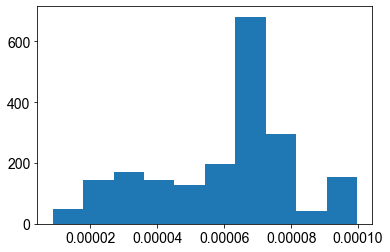

In [78]:
plt.hist(k_anox)

In [127]:
interval3 = [296.5* -1e6, 297.5* -1e6] 
interval4 = [293.4* -1e6, 294.2* -1e6]

ind0 = np.where(t_eval<interval3[0])
ind1 = np.where(t_eval>interval3[1])
ind = np.intersect1d(ind0, ind1)

d238u_ind3 = d238u[:,ind]

bg_ind3 = np.max(d238u_ind3, axis = 1)
ex_ind3 = np.min(d238u_ind3, axis = 1)
ex3 = bg_ind3 - ex_ind3



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [129]:
interval3 = [296.5* -1e6, 297.5* -1e6] 
interval4 = [293.4* -1e6, 294.2* -1e6]

ind0 = np.where(t_eval<interval3[0])
ind1 = np.where(t_eval>interval3[1])
ind = np.intersect1d(ind0, ind1)

d238u_ind3 = d238u_mean[ind]

bg_ind3 = np.max(d238u_ind3)
ex_ind3 = np.min(d238u_ind3)
ex3 = bg_ind3 - ex_ind3

ex3

0.08051474737847619

In [130]:
interval3 = [296.5* -1e6, 297.5* -1e6] 
interval4 = [293.4* -1e6, 294.2* -1e6]

ind0 = np.where(t_eval<interval4[0])
ind1 = np.where(t_eval>interval4[1])
ind = np.intersect1d(ind0, ind1)

d238u_ind3 = d238u_mean[ind]

bg_ind3 = np.max(d238u_ind3)
ex_ind3 = np.min(d238u_ind3)
ex3 = bg_ind3 - ex_ind3

ex3

0.07317568967185462

In [115]:
print(np.mean(ex3))
print(np.std(ex3))

0.08051842664296893
0.0581246797163575


In [126]:
np.std(ex4)

0.07599910471497133

In [123]:
ind0 = np.where(t_eval<interval4[0])
ind1 = np.where(t_eval>interval4[1])
ind = np.intersect1d(ind0, ind1)

d238u_ind4 = d238u[:,ind]

bg_ind4 = np.max(d238u_ind4, axis = 1)
ex_ind4 = np.min(d238u_ind4, axis = 1)
ex4 = bg_ind4 - ex_ind4


In [124]:
print(np.mean(ex4))
print(np.std(ex4))

0.07508074026532782
0.07599910471497133


In [90]:
writer = pd.ExcelWriter(f'{exp_name}_mcmc_results.xlsx')
pd.DataFrame(pco2_results, index = t_eval).to_excel(writer,sheet_name='pCO2')
pd.DataFrame(po2_results, index = t_eval).to_excel(writer,sheet_name='pO2')
pd.DataFrame(anox_results, index = t_eval).to_excel(writer,sheet_name='anox')
pd.DataFrame(d238u_results, index = t_eval).to_excel(writer,sheet_name='d238u')
pd.DataFrame(cinput_results, index = t_eval).to_excel(writer,sheet_name='c_emi')
pd.DataFrame(p_p0_results, index = t_eval).to_excel(writer,sheet_name='P')
pd.DataFrame(anox_mean, index = t_eval).to_excel(writer,sheet_name='anox_mean')
pd.DataFrame(d238u_mean, index = t_eval).to_excel(writer,sheet_name='d238u_mean')
writer.save()

In [32]:
# proxy data
raw_pco2 = pd.read_excel('raw_data.xlsx', sheet_name= 'pco2_raw')
raw_pco2['age_Ma'] = raw_pco2['age']/1e6

raw_u = pd.read_excel('raw_data.xlsx', sheet_name= 'u')
raw_u['age_Ma'] = raw_u['age']/1e6

raw_d13c = pd.read_excel('raw_data.xlsx', sheet_name= 'd13c_raw')
raw_d13c['age_Ma'] = raw_d13c['age']/1e6

# read the modeling results from GEOCARBSURF and COPSE
geocarb = pd.read_excel('model_comp.xlsx', sheet_name= 'geocarb')
copse = pd.read_excel('model_comp.xlsx', sheet_name= 'copse')
geocarbor_o2 =  pd.read_excel('model_comp.xlsx', sheet_name= 'geocarbsulfor_o2')
geocarbor_o2 = geocarbor_o2[geocarbor_o2.Age >= -310 ]
geocarbor_o2 = geocarbor_o2[geocarbor_o2.Age <= -290 ]
geocarbor_co2 =  pd.read_excel('model_comp.xlsx', sheet_name= 'geocarbsulfor_co2')
geocarbor_co2 = geocarbor_co2[geocarbor_co2.Age >= -310 ]
geocarbor_co2 = geocarbor_co2[geocarbor_co2.Age <= -290 ]

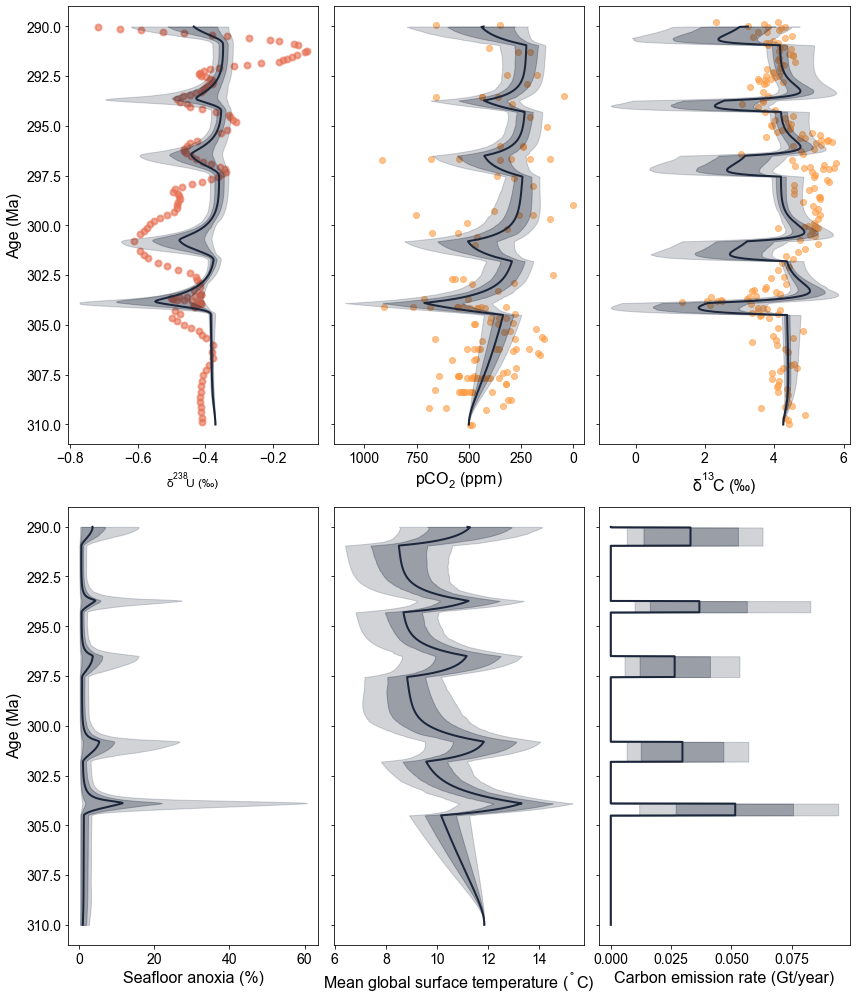

In [68]:
fig_version = f'{exp_name}_68_95'
# Fig. 3
fill_color =  '#1b263b'
line_color = '#1b263b'
proxy_color = '#FE9C43'
proxy_color1 = '#e76f51'

fig, axes = plt.subplots(figsize = (12,14),nrows=2, ncols=3, sharey=True)
alpha_95 = 0.2
alpha_68 = 0.3
# A: d238u
axes[0,0].scatter( raw_u.u.values-0.27,raw_u.age.values, color = proxy_color1, alpha = 0.6, lw=2, label = 'LOESS proxy data')


axes[0,0].plot( d238u_mean,-age, color = line_color, ls = '-', lw = 2)
# 95%
axes[0,0].fill_betweenx(-age, d238u_results[:,0], d238u_results[:,4], color = fill_color, alpha = alpha_95)
# 68%
axes[0,0].fill_betweenx(-age, d238u_results[:,1], d238u_results[:,3], color = fill_color, alpha = alpha_68)
# axes[0,0].set_xlim((-1.0,0.0))
# B: pCO2

axes[0,1].scatter( raw_pco2.pco2, -raw_pco2.age_Ma.values,color = proxy_color, alpha = 0.6, label = 'Proxy data')
axes[0,1].plot(pco2_mean,-age,  color =line_color, ls = '-', lw = 2)
axes[0,1].fill_betweenx(-age, pco2_results[:,0], pco2_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,1].fill_betweenx(-age, pco2_results[:,1], pco2_results[:,3], color = fill_color, alpha = alpha_68)
axes[0,1].invert_xaxis()

# C: d13c
axes[0,2].scatter( raw_d13c.d13c,-raw_d13c.age_Ma.values,color = proxy_color, alpha = 0.6, label = 'Proxy data')
axes[0,2].plot(d13c_mean, -age, color =line_color, ls = '-', lw = 2)
axes[0,2].fill_betweenx(-age, d13c_results[:,0], d13c_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,2].fill_betweenx(-age, d13c_results[:,1], d13c_results[:,3], color = fill_color, alpha = alpha_68)

# D: fanox
axes[1,0].plot( anox_mean,-age, color = line_color, ls = '-', lw = 2)
axes[1,0].fill_betweenx(-age, anox_results[:,0], anox_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,0].fill_betweenx(-age, anox_results[:,1], anox_results[:,3], color = fill_color, alpha = alpha_68)
# E: Temperature
axes[1,1].plot( Temperature_mean-273.15,-age, color = line_color, ls = '-', lw = 2)
axes[1,1].fill_betweenx(-age, Temperature_results[:,0]-273.15, Temperature_results[:,4]-273.15, color = fill_color, alpha = alpha_95)
axes[1,1].fill_betweenx(-age, Temperature_results[:,1]-273.15, Temperature_results[:,3]-273.15, color = fill_color, alpha = alpha_68)



# F: Carbon emission rate

axes[1,2].plot(cinput_mean, -age, color = line_color, ls = '-', lw = 2)
axes[1,2].fill_betweenx(-age, cinput_results[:,0], cinput_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,2].fill_betweenx(-age, cinput_results[:,1], cinput_results[:,3], color = fill_color, alpha = alpha_68)





# xaxis
axes[0,0].set_xlabel(r"$\delta^{238}\!U$ (" + u"\u2030" + ")", fontsize = 12)
axes[0,1].set_xlabel('pCO$_2$ (ppm)')
axes[0,2].set_xlabel(r"$\delta^{13}\!C$ (" + u"\u2030" + ")")
# axes[2,0].set_xlabel(r'$O_2$ (PAL)')

# axes[3,0].set_xlabel('Relative silicate weatherability')
# ax.set_ylabel(r'Emissions (Gt C $yr^{-1}$)')
axes[1,0].set_xlabel('Seafloor anoxia (%)')
axes[1,1].set_xlabel(r'Mean global surface temperature ($^\circ$C)')
axes[1,2].set_xlabel('Carbon emission rate (Gt/year)')


# xaxis
axes[0,0].set_ylabel('Age (Ma)', fontsize = 16)
axes[1,0].set_ylabel('Age (Ma)', fontsize = 16)

# y range
plt.setp(axes, ylim=[289, 311])




plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'Fig3_{fig_version}.pdf', dpi = 200)



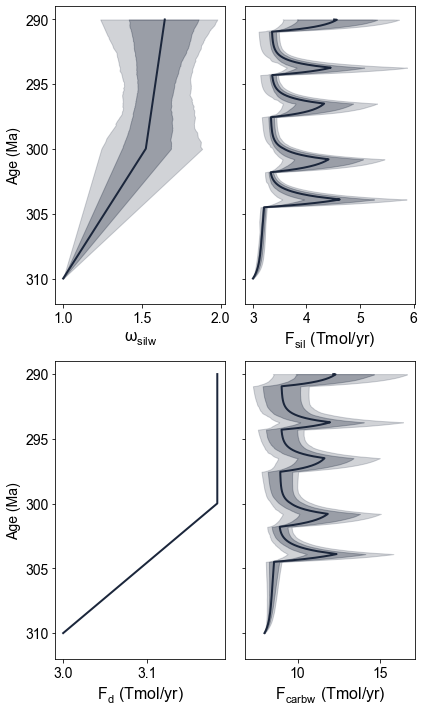

In [61]:
# params, degassing + weathering + silicate weatherability

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16


fig, axes = plt.subplots(figsize = (6,10),nrows=2, ncols=2, sharey=True)

# A: Silicate weatherability
axes[0,0].plot( w_silw_mean, -age, color = line_color, ls = '-', lw = 2)
axes[0,0].fill_betweenx(-age, w_silw_results[:,0], w_silw_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,0].fill_betweenx(-age, w_silw_results[:,1], w_silw_results[:,3], color = fill_color, alpha = alpha_68)


# # axes[2,0].plot(age, w_silw_results[:,1], color = line_color, ls = '-', lw = 2)

# C: degassing
axes[1,0].plot(ccdeg_mean, -age, color =line_color, ls = '-', lw = 2)

# B: silicate weathering
axes[0,1].plot( silw_mean, -age, color =line_color, ls = '-', lw = 2)
axes[0,1].fill_betweenx(-age, silw_results[:,0], silw_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,1].fill_betweenx(-age, silw_results[:,1], silw_results[:,3], color = fill_color, alpha = alpha_68)

# D: carbonate weathering
axes[1,1].plot( carbw_mean, -age, color =line_color, ls = '-', lw = 2)
axes[1,1].fill_betweenx(-age, carbw_results[:,0], carbw_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,1].fill_betweenx(-age, carbw_results[:,1], carbw_results[:,3], color = fill_color, alpha = alpha_68)



# xaxis
axes[1,0].set_xlabel(r'F$_d$ (Tmol/yr)')
axes[1,1].set_xlabel(r'F$_{carbw}$ (Tmol/yr)')

axes[0,1].set_xlabel(r'F$_{sil}$ (Tmol/yr)')
axes[0,0].set_xlabel(r'$\omega$$_{silw}$')



# axes[3,0].set_ylabel('CCD (km)')
# axes[3,0].invert_yaxis()

# axes[3,1].set_ylabel("%wt $CaCO_{3}$")
# axes[3,1].invert_yaxis()

# xaxis
axes[0,0].set_ylabel('Age (Ma)', fontsize = 14)
axes[1,0].set_ylabel('Age (Ma)', fontsize = 14)

# x range
plt.setp(axes, ylim=[289, 312])
plt.gca().invert_yaxis()

# plot proxy data

plt.tight_layout()
plt.savefig(f'FigS8_{fig_version}.pdf', dpi = 200)



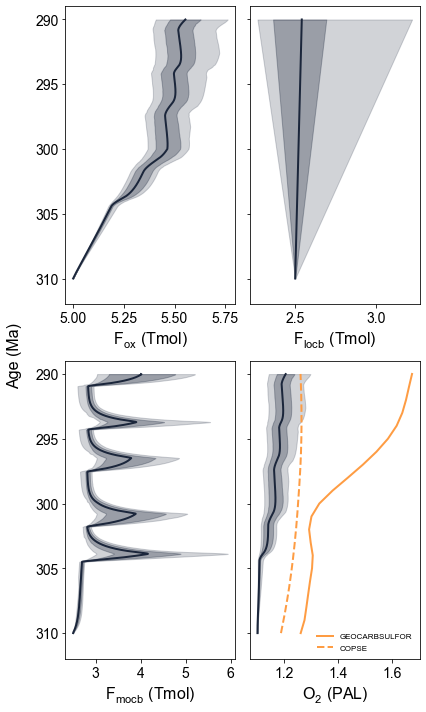

In [62]:
# params, organic carbon

fig, axes = plt.subplots(figsize = (6,10),nrows=2, ncols=2, sharey=True)




axes[0,0].plot(oxidw_mean, -age, color =line_color, ls = '-', lw = 2)
axes[0,0].fill_betweenx(-age, oxidw_results[:,0], oxidw_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,0].fill_betweenx(-age, oxidw_results[:,1], oxidw_results[:,3], color = fill_color, alpha = alpha_68)

axes[0,1].plot( locb_mean, -age, color =line_color, ls = '-', lw = 2)
axes[0,1].fill_betweenx(-age, locb_results[:,0], locb_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,1].fill_betweenx(-age, locb_results[:,1], locb_results[:,3], color = fill_color, alpha = alpha_68)

axes[1,0].plot( mocb_mean,-age, color =line_color, ls = '-', lw = 2)
axes[1,0].fill_betweenx(-age, mocb_results[:,0], mocb_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,0].fill_betweenx(-age, mocb_results[:,1], mocb_results[:,3], color = fill_color, alpha = alpha_68)


axes[1,1].plot( geocarbor_o2.Mid/20.95, -geocarbor_o2.Age, ls = '-', lw = 2, color = proxy_color, label = 'GEOCARBSULFOR')
axes[1,1].plot( copse.o2_pal, -copse.age_Ma, ls = '--', lw = 2, color = proxy_color, label = 'COPSE')
axes[1,1].plot( po2_mean, -age, color = line_color, ls = '-', lw = 2)


axes[1,1].fill_betweenx(-age, po2_results[:,0], po2_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,1].fill_betweenx(-age, po2_results[:,1], po2_results[:,3], color = fill_color, alpha = alpha_68)

# axes[1,1].fill_betweenx(-geocarbor_o2.Age, geocarbor_o2['Min']/20.95, geocarbor_o2['Max']/20.95, color = proxy_color, alpha = alpha_95)

axes[1,1].legend( borderaxespad=0.2, borderpad=0.8, labelspacing=0.6,
                  edgecolor='white', fontsize=8, )




# yaxis
axes[0,0].set_xlabel(r'F$_{ox}$ (Tmol)')
axes[0,1].set_xlabel(r'F$_{locb}$ (Tmol)')

axes[1,0].set_xlabel(r'F$_{mocb}$ (Tmol)')
axes[1,1].set_xlabel(r'$O_2$ (PAL)')

# xaxis
fig.supylabel('Age (Ma)', fontsize = 16)

# x range
plt.setp(axes, ylim=[289, 312])
plt.gca().invert_yaxis()
# plot proxy data

plt.tight_layout()
plt.savefig(f'FigS6_{fig_version}.pdf', dpi = 200)



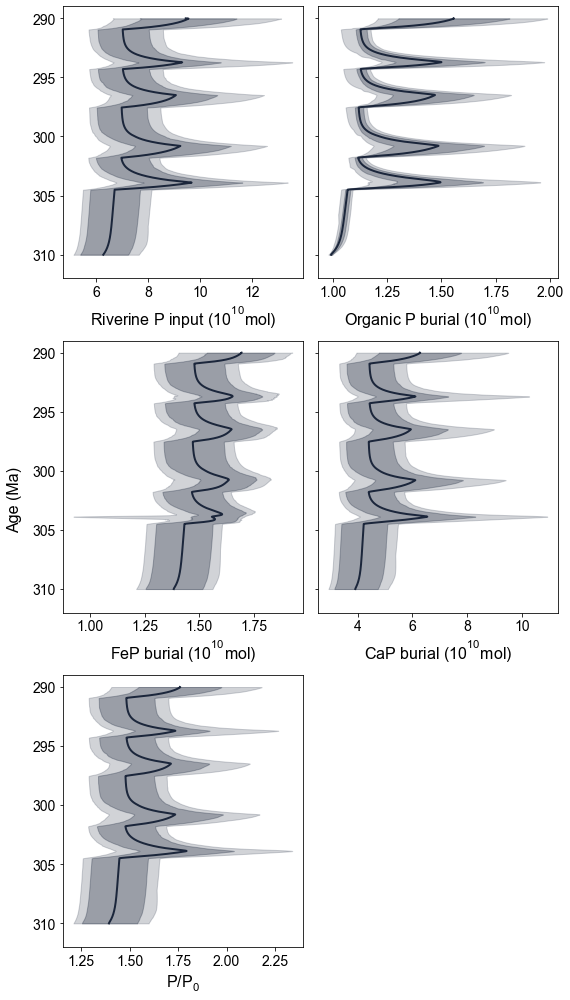

In [63]:
# params, organic carbon

fig, axes = plt.subplots(figsize = (8,14),nrows=3, ncols=2, sharey=True)

axes[2,1].remove()

axes[0,0].plot( phosw_mean,-age, color =line_color, ls = '-', lw = 2)
axes[0,0].fill_betweenx(-age, phosw_results[:,0], phosw_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,0].fill_betweenx(-age, phosw_results[:,1], phosw_results[:,3], color = fill_color, alpha = alpha_68)

axes[0,1].plot( mopb_mean, -age,color =line_color, ls = '-', lw = 2)
axes[0,1].fill_betweenx(-age, mopb_results[:,0], mopb_results[:,4], color = fill_color, alpha = alpha_95)
axes[0,1].fill_betweenx(-age, mopb_results[:,1], mopb_results[:,3], color = fill_color, alpha = alpha_68)

axes[1,0].plot( fepb_mean,-age, color =line_color, ls = '-', lw = 2)
axes[1,0].fill_betweenx(-age, fepb_results[:,0], fepb_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,0].fill_betweenx(-age, fepb_results[:,1], fepb_results[:,3], color = fill_color, alpha = alpha_68)

axes[1,1].plot( capb_mean, -age,color =line_color, ls = '-', lw = 2)
axes[1,1].fill_betweenx(-age, capb_results[:,0], capb_results[:,4], color = fill_color, alpha = alpha_95)
axes[1,1].fill_betweenx(-age, capb_results[:,1], capb_results[:,3], color = fill_color, alpha = alpha_68)

axes[2,0].plot( p_p0_mean, -age, color =line_color, ls = '-', lw = 2)
axes[2,0].fill_betweenx(-age, p_p0_results[:,0], p_p0_results[:,4], color = fill_color, alpha = alpha_95)
axes[2,0].fill_betweenx(-age, p_p0_results[:,1], p_p0_results[:,3], color = fill_color, alpha = alpha_68)

# yaxis
axes[0,0].set_xlabel(r'Riverine P input (10$^{10}$mol)')
axes[0,1].set_xlabel(r'Organic P burial (10$^{10}$mol)')

axes[1,0].set_xlabel(r'FeP burial (10$^{10}$mol)')
axes[1,1].set_xlabel(r'CaP burial (10$^{10}$mol)')

axes[2,0].set_xlabel(r'P/P$_0$')

# xaxis
fig.supylabel('Age (Ma)', fontsize = 16)

# x range
plt.setp(axes, ylim=[289, 312])

# plot proxy data
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'FigS7_{fig_version}.pdf', dpi = 200)



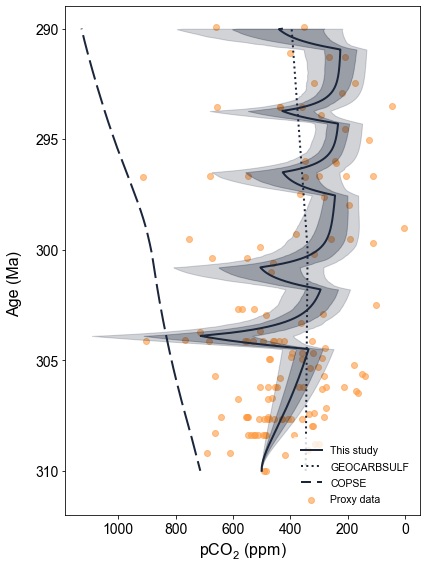

In [64]:
fig, ax = plt.subplots(figsize = (6,8),nrows=1, ncols=1)

ax.scatter( raw_pco2.pco2, -raw_pco2.age_Ma.values, color = proxy_color, alpha = 0.6, label = 'Proxy data')
ax.plot(pco2_mean,-age,  color =line_color, ls = '-', lw = 2, label = 'This study')
ax.fill_betweenx(-age, pco2_results[:,0], pco2_results[:,4], color = fill_color, alpha = alpha_95)
ax.fill_betweenx(-age, pco2_results[:,1], pco2_results[:,3], color = fill_color, alpha = alpha_68)

ax.plot( geocarb.pco2, -geocarb.age_Ma, color =line_color, ls = 'dotted', lw = 2, label = 'GEOCARBSULF')
ax.plot( copse.CO2atm, -copse.age_Ma, color = line_color, ls = (5,(10,3)), lw = 2, label = 'COPSE')

ax.set_xlabel('pCO$_2$ (ppm)')
fig.supylabel('Age (Ma)', fontsize = 16)
# x range
plt.setp(ax, ylim=[289, 312])
# plot proxy data
ax.legend( borderaxespad=0.2, borderpad=0.8, labelspacing=0.6,
                  edgecolor='white', fontsize=10.5, )
ax.invert_xaxis()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(f'FigS5_{fig_version}.pdf')
